#### Library imports

In [1]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Lambda, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from src.utils import load_data
from tensorflow import keras
import albumentations as A
import tensorflow as tf
import numpy as np
import os

#### Load data

In [2]:
img_data, label_data = load_data(reshape = False, scale_percent = 10, resize_only = True)

Loading ../InsulatorsDataSet/03 Extraction/ images...
Loading ../InsulatorsDataSet/04 Extraction/ images...
Loading ../InsulatorsDataSet/05 Extraction/ images...
Loading ../InsulatorsDataSet/06 Extraction/ images...
Loading ../InsulatorsDataSet/07 Extraction/ images...
Loading ../InsulatorsDataSet/08 Extraction/ images...


#### Data augmentation

In [3]:
transform = A.Compose([
    A.Rotate(limit = 360, border_mode = 1, p = 1)
])

def augmentation(images, labels, transform, spr):
  # spr: samples per image
  new_images = []
  new_labels = []
  for i in range(len(images)):
    # se agrega la imagen original
    new_images.append(images[i])
    # se agregan "spr" rotaciones de la imagen original
    for _ in range(spr):
      transformed = transform(image = images[i])
      transformed_img = transformed["image"]
      new_images.append(transformed_img)
    # Se agregan los mismos spr + 1 labels (las imagenes rotadas y la original!)
    new_labels += [labels[i]] * (spr + 1)
  return new_images, new_labels

samples_per_image = 10
new_images, new_labels = augmentation(img_data, label_data, transform, samples_per_image)

#### Data preparation

In [70]:
# images = np.array(new_images) / 255.0 # normalize input
images = np.array(new_images).astype("float64")
images -= np.mean(images, axis = 0)
images /= np.std(images, axis = 0)

labels = np.array(new_labels)

In [4]:
np.random.seed(813)

def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis = axis)
    return np.take_along_axis(a, idx, axis = axis)

def train_val_test_split(images, labels, N_VALIDATION, N_TRAIN, N_TEST):
    
    idx = shuffle_along_axis(np.arange(N_VALIDATION + N_TRAIN + N_TEST), 0)
    
    X_train = images[idx[:N_TRAIN]]
    y_train = labels[idx[:N_TRAIN]]

    X_val = images[idx[N_TRAIN:N_TRAIN+N_VALIDATION]]
    y_val = labels[idx[N_TRAIN:N_TRAIN+N_VALIDATION]]

    X_test = images[idx[N_TRAIN+N_VALIDATION:]]
    y_test = labels[idx[N_TRAIN+N_VALIDATION:]]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
N_VALIDATION = 132
N_TRAIN = 1056
N_TEST = 132

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(images, labels, N_VALIDATION, N_TRAIN, N_TEST)

In [6]:
def plot(model, suptitle, legend_1, legend_2, fig_name):
    fig, axes = plt.subplots(2, sharex = True, figsize = (12, 8))
    fig.suptitle(suptitle)
    
    axes[0].set_ylabel("Loss", fontsize = 14)
    axes[0].plot(model.history.history['loss'])
    axes[0].plot(model.history.history['val_loss'])
    axes[0].legend([legend_1, legend_2], loc = 'lower right')
    
    axes[1].set_ylabel("Accuracy", fontsize = 14)
    axes[1].set_xlabel("Epoch", fontsize = 14)
    axes[1].plot(model.history.history['accuracy'])
    axes[1].plot(model.history.history['val_accuracy'])
    axes[1].legend([legend_1, legend_2], loc = 'lower right')
    plt.savefig(fig_name)
    plt.show()

### AlexNet Model

In [128]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def AlexNet():
    # ref: https://vitiya99.medium.com/implement-alexnet-model-from-scratch-8201f3264b91
    
    # Pre-processing model
    in_layer = Input(shape = (298, 531, 3))
    l_layer = Lambda(lambda image: tf.image.resize(image, (227, 227)))(in_layer)
    in_model = Model(inputs = in_layer, outputs = l_layer)
    
    # Creating a Sequential model
    model = Sequential()

    model.add(in_model)
    
    # 1st Convolution Layer
    model.add(Conv2D(filters=96, kernel_size=(11,11), input_shape=(227, 227, 3), strides=(4,4), padding='valid'))
    # Normalization
    model.add(BatchNormalization())
    # Activation Function
    model.add(Activation('relu'))
    # Max-Pooling
    model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))
    
    # 2nd Convolution Layer
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
    # Normalization
    model.add(BatchNormalization())
    # Activation Function
    model.add(Activation('relu'))
    # Max-Pooling
    model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))
    
    # 3rd Convolution Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
    # Normalization
    model.add(BatchNormalization())
    # Activation Function
    model.add(Activation('relu'))
    
    # 4th Convolution Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same'))
    # Normalization
    model.add(BatchNormalization())
    # Activation Function
    model.add(Activation('relu'))
    
    # 5th Convolution Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    # Normalization
    model.add(BatchNormalization())
    # Activation Function
    model.add(Activation('relu'))
    # Max-Pooling
    model.add(MaxPooling2D((3,3), strides=(2,2), padding='valid'))
    
    # Flattening before passing to the Dense layer
    model.add(Flatten())
    
    # 1st Dense Layer
    model.add(Dense(4096))
    # Dropout
    model.add(Dropout(0.5))
    # Normalization
    model.add(BatchNormalization())
    # Activation Function
    model.add(Activation('relu'))
    
    # 2nd Dense Layer
    model.add(Dense(4096))
    # Dropout
    model.add(Dropout(0.5))
    # Normalization
    model.add(BatchNormalization())
    # Activation Function
    model.add(Activation('relu'))
    
    # Output softmax Layer
    model.add(Dense(6))
    # Activation Function
    model.add(Activation('softmax'))

    # Compiling
    # opt = keras.optimizers.Adam(learning_rate=0.01)
    # model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer = 'nadam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

alexnet = AlexNet()

In [125]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='auto', verbose=True)

In [127]:
checkpoint_path = './alexnetmodel.{epoch:02d}-{val_loss:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max', verbose=True)

In [129]:
alexnet.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks=[early_stopper, cp_callback])

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.6802 - accuracy: 0.4072
Epoch 1: val_accuracy improved from -inf to 0.37121, saving model to .\alexnetmodel.01-79.6649.h5
33/33 [==============================] - 94s 3s/step - loss: 1.6802 - accuracy: 0.4072 - val_loss: 79.6649 - val_accuracy: 0.3712
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.8336 - accuracy: 0.6562
Epoch 2: val_accuracy improved from 0.37121 to 0.37879, saving model to .\alexnetmodel.02-37.7617.h5
33/33 [==============================] - 97s 3s/step - loss: 0.8336 - accuracy: 0.6562 - val_loss: 37.7617 - val_accuracy: 0.3788
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.6503 - accuracy: 0.7547
Epoch 3: val_accuracy did not improve from 0.37879
33/33 [==============================] - 84s 3s/step - loss: 0.6503 - accuracy: 0.7547 - val_loss: 35.9426 - val_accuracy: 0.3030
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.5462

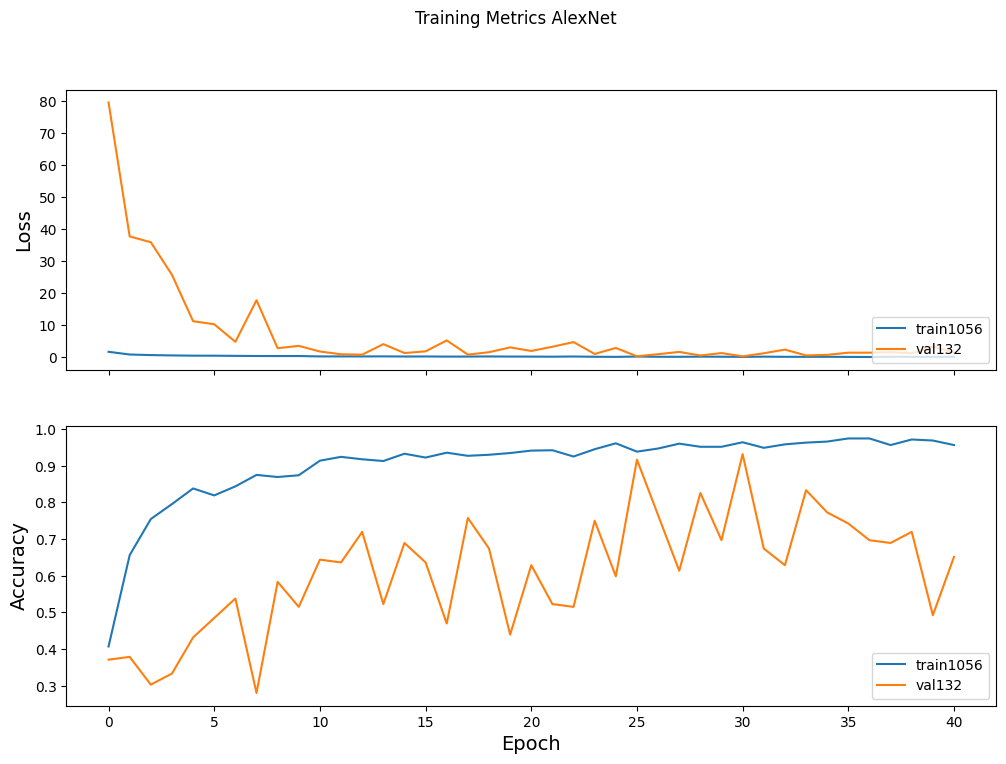

In [132]:
plot(alexnet, "Training Metrics AlexNet", "train1056", "val132", "alexnet_train1056_val132")

In [133]:
alexnet.evaluate(X_test, y_test)

5/5 [==============================] - 2s 282ms/step - loss: 0.2941 - accuracy: 0.8864


[0.2940647006034851, 0.8863636255264282]

### InceptionV3 Transfer Learning

In [36]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

def InceptionTF(images, labels):
    # from tensorflow.keras.applications.inception_v3 import InceptionV3
    from tensorflow.keras.applications.inception_v3 import preprocess_input
    # from tensorflow.keras.applications.inception_v3 import decode_predictions

    prep_images = preprocess_input(np.array(images))
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(prep_images, np.array(labels), N_VALIDATION, N_TRAIN, N_TEST)

    base_model = InceptionV3(include_top = False)

    in_layer = Input(shape = (298, 531, 3))
    l_layer = Lambda(lambda image: tf.image.resize(image, (299, 299)))(in_layer)
    in_model = Model(inputs = in_layer, outputs = l_layer)

    x = in_model.output
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu')(x)
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs = in_layer, outputs = predictions)

    for layer in base_model.layers:
    	layer.trainable = False

    model.compile(optimizer = 'nadam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model, X_train, X_val, X_test, y_train, y_val, y_test

inception, iX_train, iX_val, iX_test, iy_train, iy_val, iy_test = InceptionTF(new_images, new_labels)

In [37]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='auto', verbose=True)

In [38]:
checkpoint_path = './inceptionV3modelTF.{epoch:02d}-{val_loss:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max', verbose=True)

In [39]:
inception.fit(iX_train, iy_train, epochs = 100, validation_data = (iX_val, iy_val), callbacks=[early_stopper, cp_callback])

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.7673 - accuracy: 0.3438
Epoch 1: val_accuracy improved from -inf to 0.56818, saving model to .\inceptionV3modelTF.01-1.1254.h5
33/33 [==============================] - 50s 1s/step - loss: 1.7673 - accuracy: 0.3438 - val_loss: 1.1254 - val_accuracy: 0.5682
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.9592 - accuracy: 0.6288
Epoch 2: val_accuracy improved from 0.56818 to 0.66667, saving model to .\inceptionV3modelTF.02-0.8299.h5
33/33 [==============================] - 44s 1s/step - loss: 0.9592 - accuracy: 0.6288 - val_loss: 0.8299 - val_accuracy: 0.6667
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.7306 - accuracy: 0.7235
Epoch 3: val_accuracy improved from 0.66667 to 0.75758, saving model to .\inceptionV3modelTF.03-0.7253.h5
33/33 [==============================] - 45s 1s/step - loss: 0.7306 - accuracy: 0.7235 - val_loss: 0.7253 - val_accuracy: 0.7576
Epoch 4/100
3

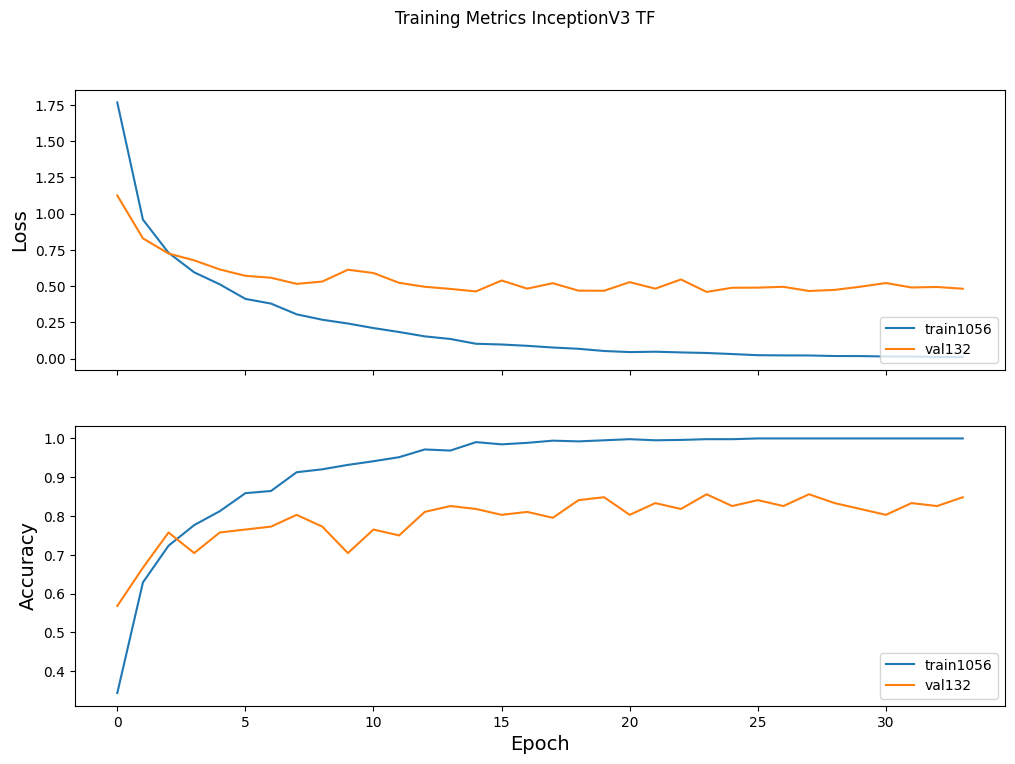

In [40]:
plot(inception, "Training Metrics InceptionV3 TF", "train1056", "val132", "inceptionV3TF_train1056_val132")

In [41]:
inception.evaluate(iX_test, iy_test)

5/5 [==============================] - 5s 901ms/step - loss: 0.6019 - accuracy: 0.8030


[0.6018850207328796, 0.8030303120613098]

### VGG16 Transfer Learning

In [42]:
from tensorflow.keras.applications.vgg16 import VGG16

def VGGTF(images, labels):
    from tensorflow.keras.applications.vgg16 import preprocess_input
    # from tensorflow.keras.applications.vgg16 import decode_predictions

    prep_images = preprocess_input(np.array(images))
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(prep_images, np.array(labels), N_VALIDATION, N_TRAIN, N_TEST)

    base_model = VGG16(include_top = False, input_shape = (224, 224, 3))

    in_layer = Input(shape =(298, 531, 3))
    l_layer = Lambda(lambda image: tf.image.resize(image, (224, 224)))(in_layer)
    in_model = Model(inputs = in_layer, outputs = l_layer)

    x = in_model.output
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu')(x)
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs = in_layer, outputs = predictions)

    for layer in base_model.layers:
    	layer.trainable = False

    model.compile(optimizer = 'nadam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model, X_train, X_val, X_test, y_train, y_val, y_test

vgg, v16X_train, v16X_val, v16X_test, v16y_train, v16y_val, v16y_test = VGGTF(new_images, new_labels)

In [43]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='auto', verbose=True)

In [44]:
checkpoint_path = './VGG16modelTF.{epoch:02d}-{val_loss:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max', verbose=True)

In [45]:
vgg.fit(v16X_train, v16y_train, epochs = 100, validation_data = (v16X_val, v16y_val), callbacks=[early_stopper, cp_callback])

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.4569 - accuracy: 0.4697
Epoch 1: val_accuracy improved from -inf to 0.68182, saving model to .\VGG16modelTF.01-0.7557.h5
33/33 [==============================] - 90s 3s/step - loss: 1.4569 - accuracy: 0.4697 - val_loss: 0.7557 - val_accuracy: 0.6818
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.5139 - accuracy: 0.8163
Epoch 2: val_accuracy improved from 0.68182 to 0.77273, saving model to .\VGG16modelTF.02-0.5324.h5
33/33 [==============================] - 85s 3s/step - loss: 0.5139 - accuracy: 0.8163 - val_loss: 0.5324 - val_accuracy: 0.7727
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.9034
Epoch 3: val_accuracy improved from 0.77273 to 0.79545, saving model to .\VGG16modelTF.03-0.4839.h5
33/33 [==============================] - 84s 3s/step - loss: 0.3097 - accuracy: 0.9034 - val_loss: 0.4839 - val_accuracy: 0.7955
Epoch 4/100
33/33 [============

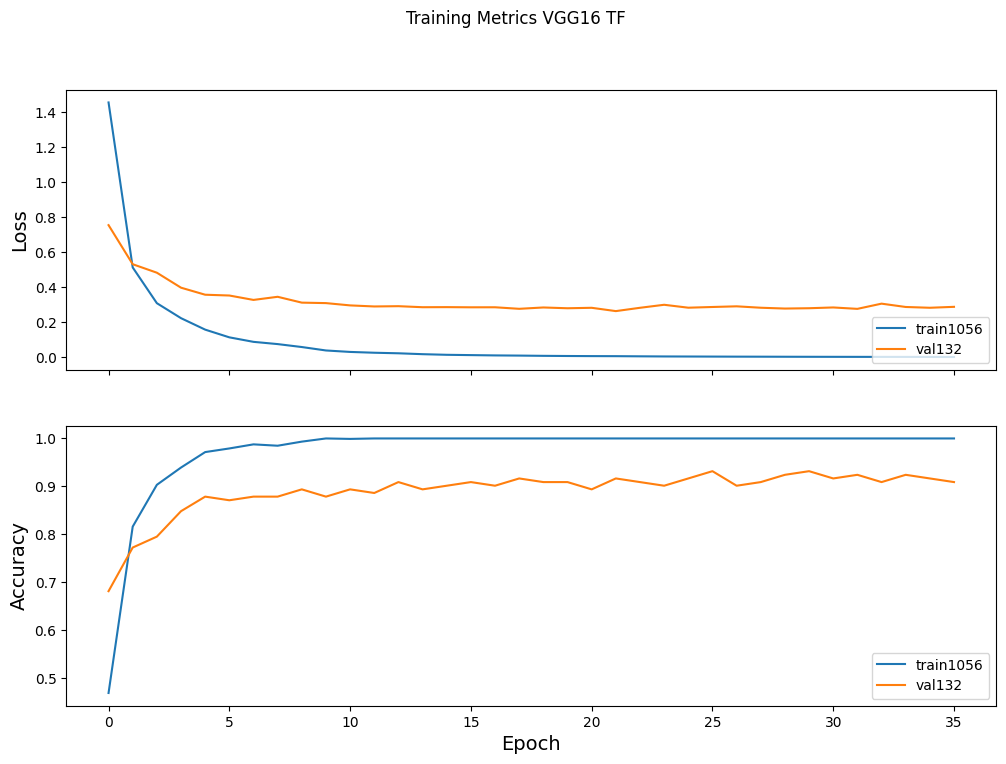

In [46]:
plot(vgg, "Training Metrics VGG16 TF", "train1056", "val132", "VGG16TF_train1056_val132")

In [47]:
vgg.evaluate(v16X_test, v16y_test)

5/5 [==============================] - 8s 2s/step - loss: 0.2796 - accuracy: 0.8939


[0.2795678973197937, 0.8939393758773804]

### VGG19 Transfer Learning

In [53]:
from tensorflow.keras.applications.vgg19 import VGG19

def VGG19TF(images, labels):
    from tensorflow.keras.applications.vgg19 import preprocess_input
    # from tensorflow.keras.applications.vgg16 import decode_predictions

    prep_images = preprocess_input(np.array(images))
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(prep_images, np.array(labels), N_VALIDATION, N_TRAIN, N_TEST)

    base_model = VGG19(include_top = False, input_shape = (224, 224, 3))

    in_layer = Input(shape =(298, 531, 3))
    l_layer = Lambda(lambda image: tf.image.resize(image, (224, 224)))(in_layer)
    in_model = Model(inputs = in_layer, outputs = l_layer)

    x = in_model.output
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu')(x)
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs = in_layer, outputs = predictions)

    for layer in base_model.layers:
    	layer.trainable = False

    model.compile(optimizer = 'nadam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model, X_train, X_val, X_test, y_train, y_val, y_test

vgg19, v19X_train, v19X_val, v19X_test, v19y_train, v19y_val, v19y_test = VGG19TF(new_images, new_labels)

In [54]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='auto', verbose=True)

In [55]:
checkpoint_path = './VGG19modelTF.{epoch:02d}-{val_loss:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max', verbose=True)

In [56]:
vgg19.fit(v19X_train, v19y_train, epochs = 100, validation_data = (v19X_val, v19y_val), callbacks=[early_stopper, cp_callback])

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.5480 - accuracy: 0.4612
Epoch 1: val_accuracy improved from -inf to 0.75758, saving model to .\VGG19modelTF.01-0.6972.h5
33/33 [==============================] - 102s 3s/step - loss: 1.5480 - accuracy: 0.4612 - val_loss: 0.6972 - val_accuracy: 0.7576
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.7784
Epoch 2: val_accuracy improved from 0.75758 to 0.79545, saving model to .\VGG19modelTF.02-0.5035.h5
33/33 [==============================] - 105s 3s/step - loss: 0.5853 - accuracy: 0.7784 - val_loss: 0.5035 - val_accuracy: 0.7955
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8845
Epoch 3: val_accuracy did not improve from 0.79545
33/33 [==============================] - 104s 3s/step - loss: 0.3869 - accuracy: 0.8845 - val_loss: 0.5698 - val_accuracy: 0.7803
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.2792 -

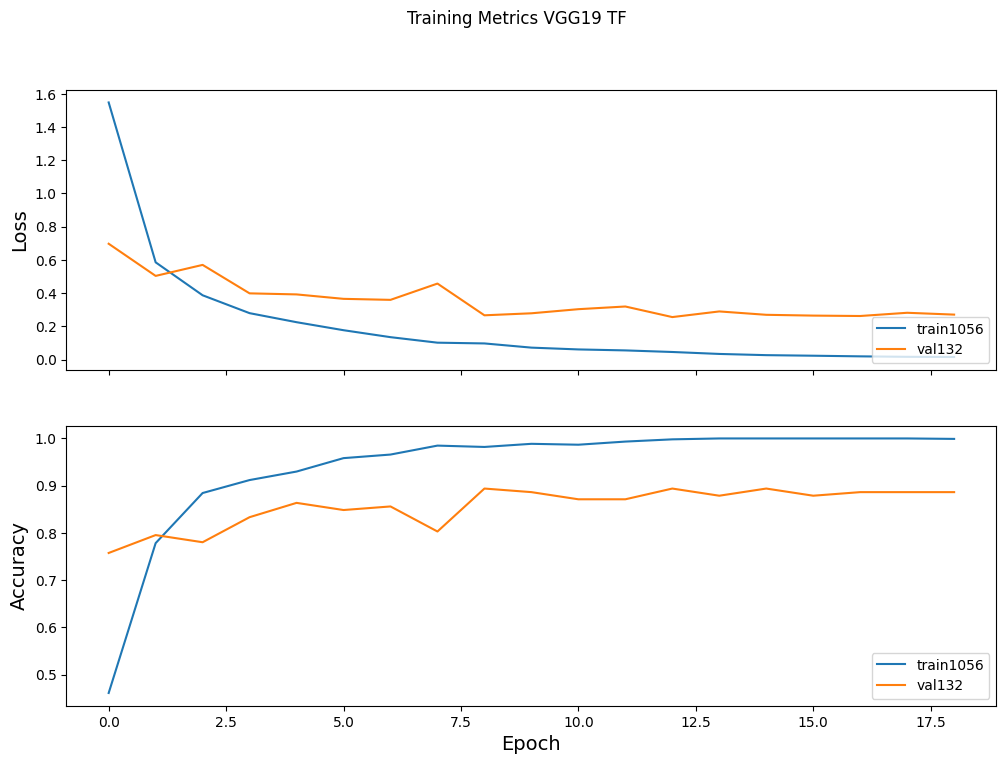

In [57]:
plot(vgg19, "Training Metrics VGG19 TF", "train1056", "val132", "VGG19TF_train1056_val132")

In [58]:
vgg19.evaluate(v19X_test, v19y_test)

5/5 [==============================] - 11s 2s/step - loss: 0.3216 - accuracy: 0.8636


[0.32156768441200256, 0.8636363744735718]

### Xception Transfer Learning

In [30]:
from tensorflow.keras.applications.xception import Xception

def XceptionTF(images, labels):
    from tensorflow.keras.applications.xception import preprocess_input
    # from tensorflow.keras.applications.vgg16 import decode_predictions

    prep_images = preprocess_input(np.array(images))
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(prep_images, np.array(labels), N_VALIDATION, N_TRAIN, N_TEST)

    base_model = Xception(include_top = False, input_shape = (224, 224, 3))

    in_layer = Input(shape =(298, 531, 3))
    l_layer = Lambda(lambda image: tf.image.resize(image, (224, 224)))(in_layer)
    in_model = Model(inputs = in_layer, outputs = l_layer)

    x = in_model.output
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu')(x)
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs = in_layer, outputs = predictions)

    for layer in base_model.layers:
    	layer.trainable = False

    model.compile(optimizer = 'nadam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return model, X_train, X_val, X_test, y_train, y_val, y_test

xception, xX_train, xX_val, xX_test, xy_train, xy_val, xy_test = XceptionTF(new_images, new_labels)

83683744/83683744 [==============================] - 4s 0us/step


In [31]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='auto', verbose=True)

In [32]:
checkpoint_path = './XceptionmodelTF.{epoch:02d}-{val_loss:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy', mode='max', verbose=True)

In [33]:
xception.fit(xX_train, xy_train, epochs = 100, validation_data = (xX_val, xy_val), callbacks=[early_stopper, cp_callback])

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.4713 - accuracy: 0.4318
Epoch 1: val_accuracy improved from -inf to 0.57576, saving model to .\XceptionmodelTF.01-1.0601.h5
33/33 [==============================] - 54s 2s/step - loss: 1.4713 - accuracy: 0.4318 - val_loss: 1.0601 - val_accuracy: 0.5758
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.8679 - accuracy: 0.6572
Epoch 2: val_accuracy improved from 0.57576 to 0.68939, saving model to .\XceptionmodelTF.02-0.8093.h5
33/33 [==============================] - 50s 2s/step - loss: 0.8679 - accuracy: 0.6572 - val_loss: 0.8093 - val_accuracy: 0.6894
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7178
Epoch 3: val_accuracy did not improve from 0.68939
33/33 [==============================] - 48s 1s/step - loss: 0.6962 - accuracy: 0.7178 - val_loss: 0.7511 - val_accuracy: 0.6742
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.575

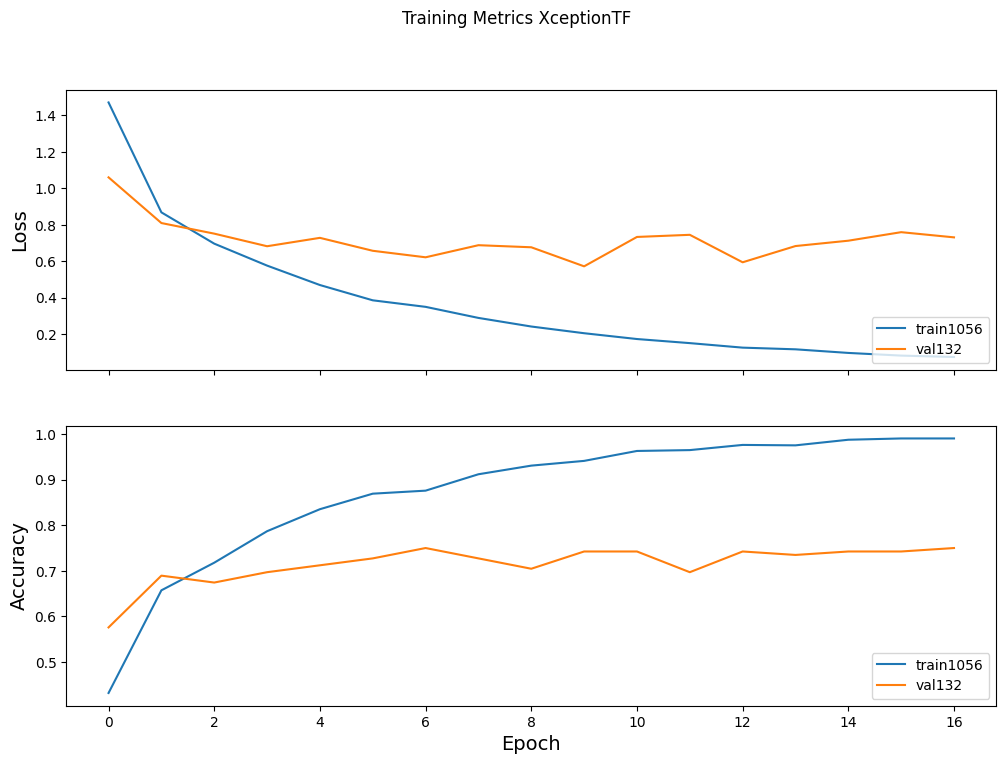

In [34]:
plot(xception, "Training Metrics XceptionTF", "train1056", "val132", "XceptionTF_train1056_val132")

In [35]:
xception.evaluate(xX_test, xy_test)

5/5 [==============================] - 5s 930ms/step - loss: 0.6698 - accuracy: 0.7348


[0.6698010563850403, 0.7348484992980957]